In [19]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [20]:
# Sækjum gögnin úr SkakgreinirGogn
import numpy as np

leikir_heild = np.loadtxt("leikir_heild_50k.csv", delimiter=",", dtype=int, comments=None)
leikir_sigurvegari = np.loadtxt("leikir_sigurvegari_50k.csv", delimiter=",", dtype=int, comments=None)

# Skoðum aðeins gögnin fyrir hvítann
leikir_heild_hvitur = []
leikir_sigurvegari_hvitur = []
nr_fyrri_leiks = 0
for i in range(leikir_heild.shape[0]):
    nr_nuverandi_leiks = leikir_heild[i,0]
    if nr_fyrri_leiks != nr_nuverandi_leiks:
        leikir_heild_hvitur.append(leikir_heild[i,:])
        leikir_sigurvegari_hvitur.append(leikir_sigurvegari[i])
    nr_fyrri_leiks = nr_nuverandi_leiks

# Skiptum gögnunum í training og test set
from sklearn.model_selection import train_test_split
#Xtr, Xts, ytr, yts = train_test_split(leikir_heild, leikir_sigurvegari, test_size=0.2, random_state=42)
Xtr, Xts, ytr, yts = train_test_split(leikir_heild_hvitur, leikir_sigurvegari_hvitur, test_size=0.2, random_state=42)
Xtr = torch.tensor(Xtr, device=device, dtype=torch.float)
ytr = torch.tensor(ytr, device=device, dtype=torch.long)
Xts = torch.tensor(Xts, device=device, dtype=torch.float)
yts = torch.tensor(yts, device=device, dtype=torch.long)

In [21]:
# Setjum gögnin á form sem hægt er að nota til að þjálfa netið
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128

train_data = TensorDataset(Xtr, ytr)
test_data = TensorDataset(Xts, yts)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [22]:
# Búum til uppsetninguna á tauganetinu
from torch import nn

n_in, n_out = len(leikir_heild[0,:]), 3
#n_hid1, n_hid2, n_hid3 = 1000, 500, 300
n_hid1, n_hid2, n_hid3 = 100, 100, 100
#n_hid1, n_hid2 = 50, 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_hid1, device=device)
        self.hidden2 = nn.Linear(n_hid1, n_hid2, device=device)
        self.hidden3 = nn.Linear(n_hid2, n_hid3, device=device)
        self.out = nn.Linear(n_hid3, n_out, device=device)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.softmax(self.out(x))
        return x

model = Net().to(device)
print(model)
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

Net(
  (hidden1): Linear(in_features=772, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
The model has 97,803 trainable parameters


In [23]:
from sklearn.metrics import accuracy_score
num_epochs = 30
train_accuracies, test_accuracies = [], []
train_loss, test_loss = [], []

learning_rate = 0.0001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train set
    for X, y in train_loader:        
        # Forward
        y_pred = model(X)
        y_pred_labels = torch.argmax(y_pred, axis=1)
        loss = loss_function(y_pred, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_accuracies.append(accuracy_score(ytr.cpu(), torch.argmax(model(Xtr), axis=1).cpu()))
    train_loss.append(loss.item())
    
    # Test set
    X, y = next(iter(test_loader))
    #y = y.type(torch.LongTensor).to(device)
    y_pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(accuracy_score(yts.cpu(), torch.argmax(model(Xts), axis=1).cpu()))
    test_loss.append(loss_function(model(X), y).item())

Text(0.5, 0, 'Ítranir')

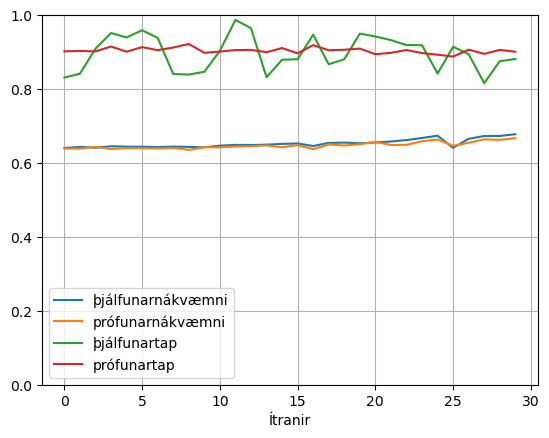

In [24]:
# Sýnum niðurstöður
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='þjálfunarnákvæmni')
plt.plot(test_accuracies, label='prófunarnákvæmni')
plt.plot(train_loss, label='þjálfunartap')
plt.plot(test_loss, label='prófunartap')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Ítranir')